In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import lenstronomy
import numpy as np
import os
import pickle
import copy
import time
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import h5py
from pprint import pprint
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import LogFormatter 
import matplotlib.colors as colors

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.ImSim.differential_extinction import DifferentialExtinction
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
from lenstronomy.Util import param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import pickle
import joblib

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print(base_path)

a_1, a_2, a_3, b_2 = 1, 1, 1, 1

/Users/pierreboccard/Doc/EPFL/PDM/Files


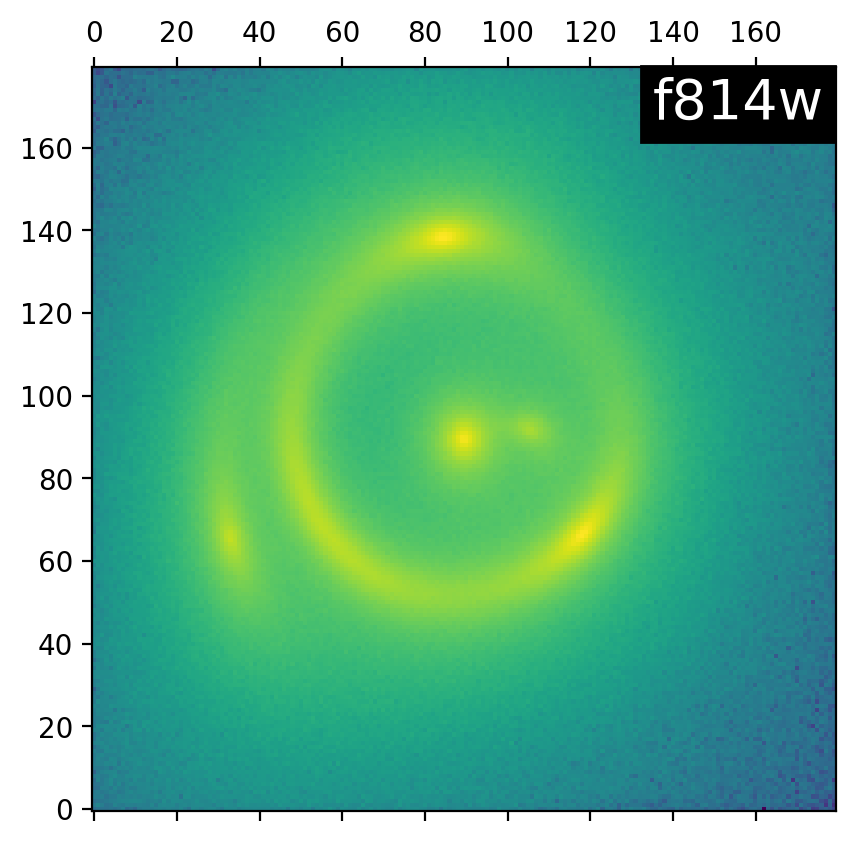

In [23]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 

background_rms = .005  # background noise per pixel
exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 180  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.15  # full width half max of PSF
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']

psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format('f814w'))
f = h5py.File(psf_file, 'r')
kernel_point_source = f['kernel_point_source'][()]
f.close()
kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
psf_class = PSF(**kwargs_psf)

ra_source1, dec_source1 = 0.2, 0.5
ra_source2, dec_source2 = -0.7, 0.
lens_model_list = ['EPL', 'SIS', 'SIS']
kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.1}
kwargs_sis = {'theta_E': 0.1, 'center_x': ra_source2, 'center_y': dec_source2}
kwargs_sis2 = {'theta_E': 0.5, 'center_x': 3.5, 'center_y': 3.0}
kwargs_lens = [kwargs_spemd, kwargs_sis, kwargs_sis2]
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=0.597, z_source=2.375, lens_redshift_list=[0.597, 2.228, 0.780], cosmo = cosmo, multi_plane = True, distance_ratio_sampling=False)
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic1 = {'amp': 500, 'R_sersic': 1.3, 'n_sersic': 5, 'e1': -0.1, 'e2': 0., 'center_x': 0., 'center_y': 0.}
kwargs_lens_light = [kwargs_sersic1]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

kwargs_sersic_ellipse1 = {'amp': 400., 'R_sersic': 1., 'n_sersic': 5, 'center_x': ra_source1, 'center_y': dec_source1, 'e1': -0.1, 'e2': 0.1}
kwargs_sersic_ellipse3 = {'amp': 400., 'R_sersic': 1, 'n_sersic': 3, 'center_x': ra_source2, 'center_y': dec_source2, 'e1': -0.2, 'e2': 0.2}
kwargs_source = [kwargs_sersic_ellipse1, kwargs_sersic_ellipse3]
source_model_class = LightModel(light_model_list=source_model_list, source_redshift_list=[2.375, 2.228])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
kwargs_extinction = [{'amp': 0, 'R_sersic': 0.005, 'n_sersic': 1, 'center_x': 0, 'center_y': 0}]

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,lens_light_model_class,kwargs_numerics=kwargs_numerics)
image_simbis = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_extinction=kwargs_extinction)
poisson = image_util.add_poisson(image_simbis, exp_time=exp_time)
bkg = image_util.add_background(image_simbis, sigma_bkd=background_rms)
image_simbis = image_simbis + bkg + poisson

kwargs_data['image_data'] = image_simbis
data_class.update_data(image_simbis)

np.savetxt('image_small.txt', image_simbis)

plt.matshow(np.log10(image_simbis), origin='lower')
plt.text(135, 167, 'f814w', fontsize = 20, color = 'white',
         bbox = dict(facecolor = 'black', alpha = 1))
plt.show()


In [24]:
# from astropy.cosmology import FlatLambdaCDM, wCDM
# import astropy.units as u

# cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 

# background_rms = .005  # background noise per pixel
# exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
# numPix = 180  # cutout pixel size
# deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
# fwhm = 0.15  # full width half max of PSF
# kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
# data_class = ImageData(**kwargs_data)
# ra_at_xy_0 = kwargs_data['ra_at_xy_0']
# dec_at_xy_0 = kwargs_data['dec_at_xy_0']
# print(ra_at_xy_0)
# print(dec_at_xy_0)

# psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format('f475x'))
# f = h5py.File(psf_file, 'r')
# kernel_point_source = f['kernel_point_source'][()]
# f.close()
# #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
# kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
# psf_class = PSF(**kwargs_psf)

# lens_model_list = ['EPL']
# kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.1}
# kwargs_lens = [kwargs_spemd]
# lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=0.597, z_source=2.375, lens_redshift_list=[0.597], cosmo = cosmo, multi_plane = True, distance_ratio_sampling=True)
# lens_light_model_list = ['SERSIC_ELLIPSE']
# kwargs_sersic1 = {'amp': 500, 'R_sersic': 1.3, 'n_sersic': 5, 'e1': -0.1, 'e2': 0., 'center_x': 0., 'center_y': 0.}
# kwargs_lens_light = [kwargs_sersic1]
# lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
# source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
# ra_source1, dec_source1 = 0.2, 0.5
# ra_source2, dec_source2 = -0.7, 0.
# kwargs_sersic_ellipse1 = {'amp': 400., 'R_sersic': 1., 'n_sersic': 5, 'center_x': ra_source1, 'center_y': dec_source1, 'e1': -0.1, 'e2': 0.1}
# kwargs_sersic_ellipse3 = {'amp': 400., 'R_sersic': 1, 'n_sersic': 3, 'center_x': ra_source2, 'center_y': dec_source2, 'e1': -0.2, 'e2': 0.2}
# kwargs_source = [kwargs_sersic_ellipse1, kwargs_sersic_ellipse3]
# source_model_class = LightModel(light_model_list=source_model_list, source_redshift_list=[2.375, 2.228])
# kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
# a_1, a_2, a_3, b_2 = 1., 1., 1., 1.
# kwargs_special = {'scale_factor': [], 'tau0_list': [1], 'a_1': a_1, 'a_2': a_2, 'a_3': a_3, 'b_2': b_2}
# kwargs_extinction = [{'amp': 0, 'R_sersic': 0.005, 'n_sersic': 1, 'center_x': 0, 'center_y': 0}]

# imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,lens_light_model_class,kwargs_numerics=kwargs_numerics)
# image_sim2 = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_special=kwargs_special, kwargs_extinction=kwargs_extinction)
# #image_sim2 = image_sim2
# poisson = image_util.add_poisson(image_sim2, exp_time=exp_time)
# bkg = image_util.add_background(image_sim2, sigma_bkd=background_rms)
# image_sim2 = image_sim2 + bkg + poisson

# kwargs_data['image_data'] = image_sim2
# data_class.update_data(image_sim2)

# np.savetxt('image_sim_new475.txt', image_sim2)

# plt.matshow(np.log10(image_sim2), origin='lower')
# plt.text(135, 167, 'f475x', fontsize = 20, color = 'white',
#          bbox = dict(facecolor = 'black', alpha = 1))
# plt.show()


In [25]:
# from astropy.cosmology import FlatLambdaCDM, wCDM
# import astropy.units as u

# cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 

# background_rms = .01 # background noise per pixel
# exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
# numPix = 120  # cutout pixel size
# deltaPix = 0.075  # pixel size in arcsec (area per pixel = deltaPix**2)
# fwhm = 0.15  # full width half max of PSF
# kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
# data_class = ImageData(**kwargs_data)
# transform_pix2angle = kwargs_data['transform_pix2angle']
# ra_at_xy_0 = kwargs_data['ra_at_xy_0']
# dec_at_xy_0 = kwargs_data['dec_at_xy_0']

# psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format('f160w'))
# f = h5py.File(psf_file, 'r')
# kernel_point_source = f['kernel_point_source'][()]
# f.close()
# #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
# kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
# psf_class = PSF(**kwargs_psf)

# lens_model_list = ['EPL']
# kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.1}
# kwargs_lens = [kwargs_spemd]
# lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=0.597, z_source=2.375, lens_redshift_list=[0.597], cosmo = cosmo, multi_plane = True, distance_ratio_sampling=True)
# lens_light_model_list = ['SERSIC_ELLIPSE']
# kwargs_sersic1 = {'amp': 500, 'R_sersic': 1.3, 'n_sersic': 5, 'e1': -0.1, 'e2': 0., 'center_x': 0., 'center_y': 0.}
# kwargs_lens_light = [kwargs_sersic1]
# lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
# source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
# ra_source1, dec_source1 = 0.2, 0.5
# ra_source2, dec_source2 = -0.7, 0.
# kwargs_sersic_ellipse1 = {'amp': 400., 'R_sersic': 1., 'n_sersic': 5, 'center_x': ra_source1, 'center_y': dec_source1, 'e1': -0.1, 'e2': 0.1}
# kwargs_sersic_ellipse3 = {'amp': 400., 'R_sersic': 1, 'n_sersic': 3, 'center_x': ra_source2, 'center_y': dec_source2, 'e1': -0.2, 'e2': 0.2}
# kwargs_source = [kwargs_sersic_ellipse1, kwargs_sersic_ellipse3]
# source_model_class = LightModel(light_model_list=source_model_list, source_redshift_list=[2.375, 2.228])
# kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
# a_1, a_2, a_3, b_2 = 1., 1., 1., 1.
# kwargs_special = {'scale_factor': [], 'tau0_list': [1], 'a_1': a_1, 'a_2': a_2, 'a_3': a_3, 'b_2': b_2}
# kwargs_extinction = [{'amp': 0, 'R_sersic': 0.005, 'n_sersic': 1, 'center_x': 0, 'center_y': 0}]

# imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,lens_light_model_class,kwargs_numerics=kwargs_numerics)
# image_sim3 = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_special=kwargs_special, kwargs_extinction=kwargs_extinction)
# #image_sim3 = image_sim 
# poisson = image_util.add_poisson(image_sim3, exp_time=exp_time)
# bkg = image_util.add_background(image_sim3, sigma_bkd=background_rms)
# image_sim3 = image_sim3 + bkg + poisson

# kwargs_data['image_data'] = image_sim3
# data_class.update_data(image_sim3)

# #image_sim = image_sim[:,::-1]

# np.savetxt('image_sim_new160.txt', image_sim3)

# plt.matshow(np.log10(image_sim3), origin='lower')
# plt.text(90, 111, 'f160w', fontsize = 20, color = 'white',
#          bbox = dict(facecolor = 'black', alpha = 1))
# plt.show()


-1.0105996215294 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0105996215294


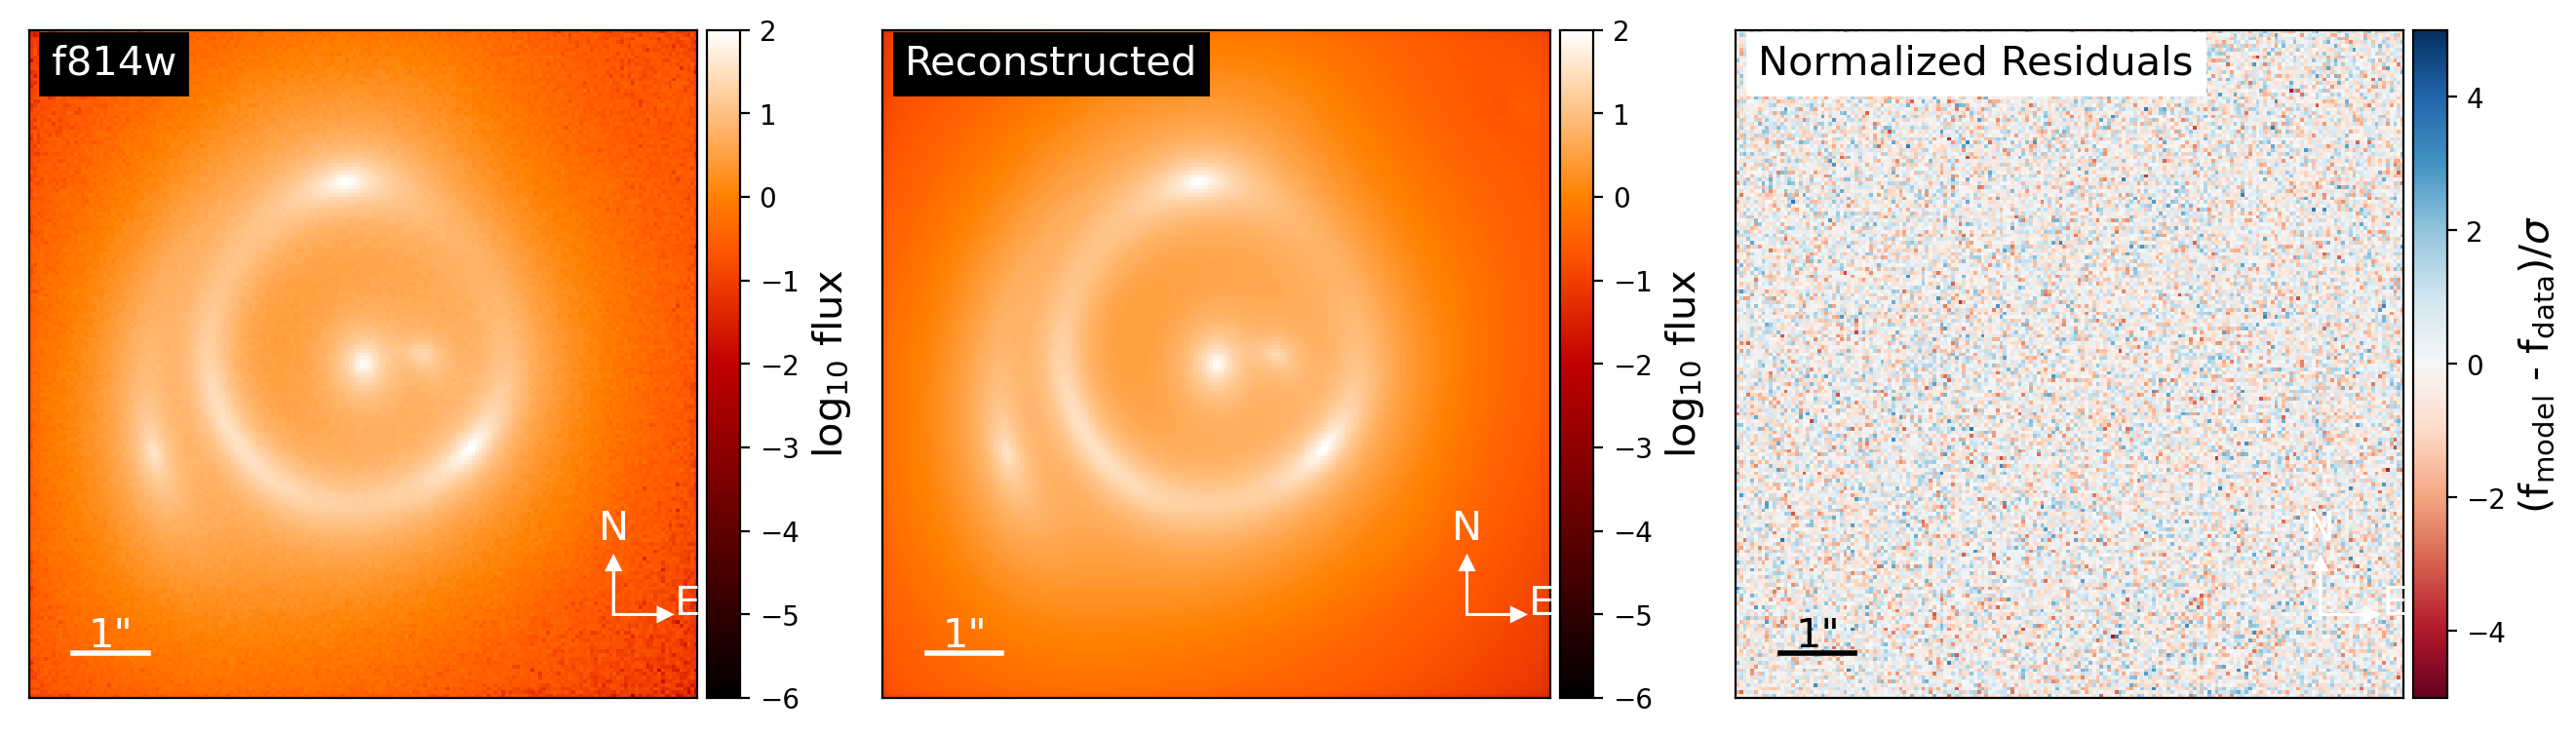

In [31]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cmap = 'cubehelix'
msh_cmap = 'RdBu'

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 

data814 = np.loadtxt('image_small.txt')

def import_data(filter_name):
    """
    """

    if filter_name == 'f814w' :

        background_rms = .005  # background noise per pixel
        exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
        numPix = 180  # cutout pixel size
        deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
        fwhm = 0.15  # full width half max of PSF
        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
        data_class = ImageData(**kwargs_data)
        psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
        f = h5py.File(psf_file, 'r')
        kernel_point_source = f['kernel_point_source'][()]
        f.close()
        #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
        kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
        psf_class = PSF(**kwargs_psf)
        kwargs_data['image_data'] = data814
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

        tampon_source = [
        {'amp': 400., 'R_sersic': 1., 'n_sersic': 5, 'center_x': ra_source1, 'center_y': dec_source1, 'e1': -0.1, 'e2': 0.1},
        {'amp': 400., 'R_sersic': 1, 'n_sersic': 3, 'center_x': ra_source2, 'center_y': dec_source2, 'e1': -0.2, 'e2': 0.2}]

        tampon_lens_light = [
        {'amp': 500, 'R_sersic': 1.3, 'n_sersic': 5, 'e1': -0.1, 'e2': 0., 'center_x': 0., 'center_y': 0.}
        ]

        kwargs_model = {'lens_model_list': ['EPL', 'SIS', 'SIS'], 
        'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], 
        'lens_light_model_list': ['SERSIC_ELLIPSE'], 
        'index_lens_light_model_list': [[0]], 
        'index_source_light_model_list': [[0, 1]], 
        'distance_ratio_sampling': False, 
        'multi_plane': True, 
        'lens_redshift_list': [0.597, 2.228, 0.780], 
        'cosmo': cosmo, 
        'z_source': 2.375, 
        'source_redshift_list': [2.375, 2.228]}

    return kwargs_data, kwargs_psf, coords, tampon_source, tampon_lens_light, kwargs_model, filter_name 

kwargs_data, kwargs_psf, coords, tampon_source, tampon_lens_light, kwargs_model, filter_name = import_data('f814w')

amp_ps = 1000

with open('known_solution_small.pickle', 'rb') as f:
    kwargs_result_old = pickle.load(f)

del kwargs_result_old['kwargs_special']

ra_source2, dec_source2 = -0.7, 0.0

tampon_lens = [{'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.1}, {'theta_E': 0.1, 'center_x': ra_source2, 'center_y': dec_source2}, {'theta_E': 0.5, 'center_x': 3.5, 'center_y': 3.0}]
kwargs_extinction = [{'amp': 0, 'R_sersic': 0.005, 'n_sersic': 1, 'center_x': 0, 'center_y': 0}]
kwargs_test = kwargs_result_old
kwargs_test['kwargs_lens'] = tampon_lens
kwargs_test['kwargs_lens_light'] = tampon_lens_light
kwargs_test['kwargs_source'] = tampon_source
kwargs_test['kwargs_ps'] = []
kwargs_test['kwargs_extinction'] = kwargs_extinction
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

f = open('known_solution_small_new.pickle','wb')
pickle.dump(kwargs_test, f)
f.close()   

with open('known_solution_small_new.pickle', 'rb') as f:
    kwargs_result_good = pickle.load(f)

lens_plot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_result_good, arrow_size=0.02, cmap_string="gist_heat", multi_band_type='single-band', linear_solver=False)
f, axes = plt.subplots(1, 3, figsize=(16, 16), sharex=False, sharey=True)
lens_plot.data_plot(ax=axes[0], band_index=0, v_max= 2, v_min=-6, text=str(filter_name))
lens_plot.model_plot(ax=axes[1], band_index=0, v_max= 2, v_min=-6)
lens_plot.normalized_residual_plot(ax=axes[2], band_index=0, v_max=5, v_min=-5, cmap=msh_cmap)
#axes[1].plot(xtest, ytest, 'xb', markersize=10)
plt.show()
#plt.close()

In [29]:
# from astropy.cosmology import FlatLambdaCDM, wCDM
# import astropy.units as u

# cmap = 'cubehelix'
# msh_cmap = 'RdBu'

# cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 

# data814 = np.loadtxt('image_sim_new814.txt')
# data814bis = np.loadtxt('image_sim_new814bis.txt')
# data475 = np.loadtxt('image_sim_new475.txt')
# data160 = np.loadtxt('image_sim_new160.txt')

# def import_data(filter_name):
#     """
#     """
#     #data_file = os.path.join(base_path, 'data', 'data_{}.hdf5'.format(filter_name))
#     #f = h5py.File(data_file, 'r')
    
#     if filter_name == 'f160w' : 

#         background_rms = .01 # background noise per pixel
#         exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
#         numPix = 120  # cutout pixel size
#         deltaPix = 0.075  # pixel size in arcsec (area per pixel = deltaPix**2)
#         fwhm = 0.15  # full width half max of PSF
#         kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
#         data_class = ImageData(**kwargs_data)
#         psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
#         f = h5py.File(psf_file, 'r')
#         kernel_point_source = f['kernel_point_source'][()]
#         f.close()
#         #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
#         kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
#         psf_class = PSF(**kwargs_psf)
#         kwargs_data['image_data'] =  data160
#         ra_at_xy_0 = kwargs_data['ra_at_xy_0']
#         dec_at_xy_0 = kwargs_data['dec_at_xy_0']
#         transform_pix2angle = kwargs_data['transform_pix2angle']
#         coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

#         tampon_source = [
#         {'amp': 400., 'R_sersic': 1., 'n_sersic': 5, 'center_x': ra_source1, 'center_y': dec_source1, 'e1': -0.1, 'e2': 0.1},
#         {'amp': 400., 'R_sersic': 1, 'n_sersic': 3, 'center_x': ra_source2, 'center_y': dec_source2, 'e1': -0.2, 'e2': 0.2}]

#         tampon_lens_light = [
#         {'amp': 500, 'R_sersic': 1.3, 'n_sersic': 5, 'e1': -0.1, 'e2': 0., 'center_x': 0., 'center_y': 0.}
#         ]

#         kwargs_model = {'lens_model_list': ['EPL'], 'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], 'lens_light_model_list': ['SERSIC_ELLIPSE'], 'index_lens_light_model_list': [[0]], 'index_source_light_model_list': [[0, 1]], 'distance_ratio_sampling': True, 'multi_plane': True, 'lens_redshift_list': [0.597], 'cosmo': cosmo, 'z_source': 2.375, 'source_redshift_list': [2.375, 2.228]}


#     if filter_name == 'f475x' : 

#         background_rms = .005  # background noise per pixel
#         exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
#         numPix = 180  # cutout pixel size
#         deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
#         fwhm = 0.15  # full width half max of PSF
#         kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
#         data_class = ImageData(**kwargs_data)
#         psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
#         f = h5py.File(psf_file, 'r')
#         kernel_point_source = f['kernel_point_source'][()]
#         f.close()
#         #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
#         kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
#         psf_class = PSF(**kwargs_psf)
#         kwargs_data['image_data'] = data475
#         ra_at_xy_0 = kwargs_data['ra_at_xy_0']
#         dec_at_xy_0 = kwargs_data['dec_at_xy_0']
#         transform_pix2angle = kwargs_data['transform_pix2angle']
#         coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

#         tampon_source = [
#         {'amp': 400., 'R_sersic': 1., 'n_sersic': 5, 'center_x': ra_source1, 'center_y': dec_source1, 'e1': -0.1, 'e2': 0.1},
#         {'amp': 400., 'R_sersic': 1, 'n_sersic': 3, 'center_x': ra_source2, 'center_y': dec_source2, 'e1': -0.2, 'e2': 0.2}]

#         tampon_lens_light = [
#         {'amp': 500, 'R_sersic': 1.3, 'n_sersic': 5, 'e1': -0.1, 'e2': 0., 'center_x': 0., 'center_y': 0.}
#         ]

#         kwargs_model = {'lens_model_list': ['EPL'], 'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], 'lens_light_model_list': ['SERSIC_ELLIPSE'], 'index_lens_light_model_list': [[0]], 'index_source_light_model_list': [[0, 1]], 'distance_ratio_sampling': True, 'multi_plane': True, 'lens_redshift_list': [0.597], 'cosmo': cosmo, 'z_source': 2.375, 'source_redshift_list': [2.375, 2.228]}


#     if filter_name == 'f814w' :

#         background_rms = .005  # background noise per pixel
#         exp_time = 70  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
#         numPix = 180  # cutout pixel size
#         deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
#         fwhm = 0.15  # full width half max of PSF
#         kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
#         data_class = ImageData(**kwargs_data)
#         psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
#         f = h5py.File(psf_file, 'r')
#         kernel_point_source = f['kernel_point_source'][()]
#         f.close()
#         #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
#         kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'kernel_point_source' : kernel_point_source,'pixel_size': deltaPix}
#         psf_class = PSF(**kwargs_psf)
#         kwargs_data['image_data'] = data814bis
#         ra_at_xy_0 = kwargs_data['ra_at_xy_0']
#         dec_at_xy_0 = kwargs_data['dec_at_xy_0']
#         transform_pix2angle = kwargs_data['transform_pix2angle']
#         coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

#         tampon_source = [
#         {'amp': 400., 'R_sersic': 1., 'n_sersic': 5, 'center_x': ra_source1, 'center_y': dec_source1, 'e1': -0.1, 'e2': 0.1},
#         {'amp': 400., 'R_sersic': 1, 'n_sersic': 3, 'center_x': ra_source2, 'center_y': dec_source2, 'e1': -0.2, 'e2': 0.2}]

#         tampon_lens_light = [
#         {'amp': 500, 'R_sersic': 1.3, 'n_sersic': 5, 'e1': -0.1, 'e2': 0., 'center_x': 0., 'center_y': 0.}
#         ]

#         kwargs_modelbis = {'lens_model_list': ['EPL', 'SIS'], 
#         'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], 
#         'lens_light_model_list': ['SERSIC_ELLIPSE'], 
#         'index_lens_light_model_list': [[0]], 
#         'index_source_light_model_list': [[0, 1]], 
#         'distance_ratio_sampling': False, 
#         'multi_plane': True, 
#         'lens_redshift_list': [0.597, 2.228], 
#         'cosmo': cosmo, 
#         'z_source': 2.375, 
#         'source_redshift_list': [2.375, 2.228]}

    

#     return kwargs_data, kwargs_psf, coords, tampon_source, tampon_lens_light, kwargs_modelbis, filter_name 

# #kwargs_data, kwargs_psf, coords, tampon_source, tampon_lens_light, kwargs_model, filter_name = import_data('f160w')
# kwargs_data, kwargs_psf, coords, tampon_source, tampon_lens_light, kwargs_modelbis, filter_name = import_data('f814w')
# #kwargs_data, kwargs_psf, coords, tampon_source, tampon_lens_light, kwargs_model, filter_name = import_data('f475x')

# amp_ps = 1000

# with open('known_solution_small.pickle', 'rb') as f:
#     kwargs_result_old = pickle.load(f)

# ra_source2, dec_source2 = -0.7, 0.0

# del kwargs_result_old['kwargs_special']

# tampon_lens = [{'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.1}, {'theta_E': 0.1, 'center_x': ra_source2, 'center_y': dec_source2}]
# kwargs_extinction = [{'amp': 0, 'R_sersic': 0.005, 'n_sersic': 1, 'center_x': 0, 'center_y': 0}]
# kwargs_testbis = kwargs_result_old
# kwargs_testbis['kwargs_lens'] = tampon_lens
# kwargs_testbis['kwargs_lens_light'] = tampon_lens_light
# kwargs_testbis['kwargs_source'] = tampon_source
# kwargs_testbis['kwargs_ps'] = []
# kwargs_testbis['kwargs_extinction'] = kwargs_extinction
# kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# f = open('known_solution_smallbis.pickle','wb')
# pickle.dump(kwargs_testbis, f)
# f.close()   

# with open('known_solution_smallbis.pickle', 'rb') as f:
#     kwargs_result_goodbis = pickle.load(f)

# lens_plot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_modelbis, kwargs_result_goodbis, arrow_size=0.02, cmap_string="gist_heat", multi_band_type='single-band', linear_solver=False)
# f, axes = plt.subplots(1, 3, figsize=(16, 16), sharex=False, sharey=True)
# lens_plot.data_plot(ax=axes[0], band_index=0, v_max= 2, v_min=-6, text=str(filter_name))
# lens_plot.model_plot(ax=axes[1], band_index=0, v_max= 2, v_min=-6)
# lens_plot.normalized_residual_plot(ax=axes[2], band_index=0, v_max=5, v_min=-5, cmap=msh_cmap)
# #axes[1].plot(xtest, ytest, 'xb', markersize=10)
# plt.show()
# #plt.close()